baseline

/home/chenxi/.conda/envs/myen/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_550614/2042864586.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['champion'] = LabelEncoder().fit_transform(X['champion'])


Linear Regression Cross-Val MSE:  0.9993214652764525
Random Forest Cross-Val MSE:  0.7586001544065702
Linear Regression RMSE: 1.0052768152091325
Random Forest RMSE: 0.8764818836949111
Linear Regression R^2: 0.6423159290059994
Random Forest R^2: 0.7280969027209707
Linear Regression MAE: 0.7964395437352974
Random Forest MAE: 0.673471572200837
Linear Regression Explained Variance: 0.6423296407899508
Random Forest Explained Variance: 0.7281010067982794


/home/chenxi/.conda/envs/myen/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/chenxi/.conda/envs/myen/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


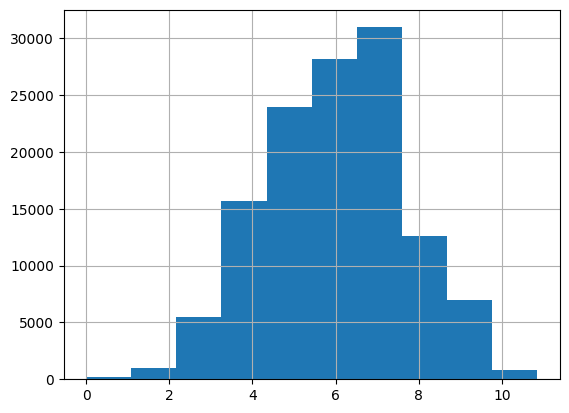

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer

# Load the dataset
file_path = '/home/chenxi/data/2023_LoL_esports_match_data_from_OraclesElixir.csv'
data = pd.read_csv(file_path)

columns_to_fix = ['kills', 'assists', 'total cs', 'towers', 'dragons']
data[columns_to_fix] = data[columns_to_fix].fillna(0)
data['impact_score'] = np.log1p(data['kills']) + np.log1p(data['assists']) + np.log1p(data['total cs'] * 0.1) + np.log1p(data['towers'] * 0.5) + np.log1p(data['dragons'] * 0.2)
target_col = 'impact_score'
data['impact_score'].describe(), data['impact_score'].hist()
# Prepare features
features = ['champion', 'killsat15', 'assistsat15', 'csat15', 'goldat15', 'xpat15', 'damagetochampions']

X = data[features]
y = data[target_col]

y.fillna(y.median(), inplace=True)
# Encode categorical feature
X['champion'] = LabelEncoder().fit_transform(X['champion'])

numeric_features = ['killsat15', 'assistsat15', 'csat15', 'goldat15', 'xpat15', 'damagetochampions']
categorical_features = ['champion']

numeric_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the models with pipelines
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the models with cross-validation
lr_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

print("Linear Regression Cross-Val MSE: ", -lr_scores.mean())
print("Random Forest Cross-Val MSE: ", -rf_scores.mean())

# Fit the models on the entire training set
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# Make predictions
lr_predictions = lr_pipeline.predict(X_test)
rf_predictions = rf_pipeline.predict(X_test)

# Evaluate the models
lr_rmse = mean_squared_error(y_test, lr_predictions, squared=False)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
lr_r2 = r2_score(y_test, lr_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
lr_ev = explained_variance_score(y_test, lr_predictions)
rf_ev = explained_variance_score(y_test, rf_predictions)

print("Linear Regression RMSE:", lr_rmse)
print("Random Forest RMSE:", rf_rmse)
print("Linear Regression R^2:", lr_r2)
print("Random Forest R^2:", rf_r2)
print("Linear Regression MAE:", lr_mae)
print("Random Forest MAE:", rf_mae)
print("Linear Regression Explained Variance:", lr_ev)
print("Random Forest Explained Variance:", rf_ev)